# BIOINF 305. Assignment - week 39.
## Assem Maratova

Download normalized gene expression data from the [Many Microbes Microarrays Database](http://m3d.mssm.edu/).  Use the file that has expression data for genes only and where replicate experiments have been averaged. Use the high-confidence RegulonDB transcription network previously created.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# setting some parameters for plots
plt.style.use('seaborn')
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title 
plt.rcParams['figure.figsize'] = 10 , 6  # default figure size

### Read RegulonDB data from file 

In [3]:
# read RegulonDB data from file 
df_regdb = pd.read_table('network_tf_gene.txt', 
                     header=None, 
                     skiprows=34, 
                     usecols=[0,1,2,4])

# standardize the data
for col in [0,1,2,4]:
    df_regdb[col] = df_regdb[col].str.lower()

# rename columns to ease reading
df_regdb = df_regdb.rename(columns={0:'tf', 
                                    1:'gene', 
                                    2:'effect', 
                                    4:'power'})

# filter the data 
filtered = (df_regdb['effect'].isin(['+','-'])) & (df_regdb['power']=='strong')

# drop duplicate rows having same tf and gene 
df_regdb = df_regdb[filtered].drop_duplicates(subset=['tf','gene'])

# filter out autoregulated tf
df_regdb = df_regdb[df_regdb.tf != df_regdb.gene]

### Read required data from Many Microbes Microarrays Database 

In [4]:
# read required data from Many Microbes Microarrays Database 
df_ecoli = pd.read_table('avg_E_coli_v4_Build_6_exps466probes4297.tab',
                         header=None, 
                         skiprows=1)

# standardize the data
df_ecoli.iloc[:,0] = df_ecoli.iloc[:,0].str.lower()

# extract gene data
df_ecoli.iloc[:,0] = df_ecoli.iloc[:,0].str.split('_').str[0]

# rename columns to ease reading
df_ecoli = df_ecoli.rename(columns = {0:'gene'})

In [5]:
print('Check if df_ecoli contains only unique genes:')
df_ecoli.gene.nunique() == df_ecoli.shape[0]

Check if df_ecoli contains only unique genes:


True

***Create versions of the expression data and transcription network restricted to the set of genes that are in common between both datasets.***

### Keep only cases where 'tf' and 'target gene' are in df_ecoli

In [6]:
# keep only cases where 'tf' and 'target gene' are in df_ecoli
df_regdb_ftr = (df_regdb[df_regdb.tf.isin(df_ecoli.gene) 
                    & df_regdb.gene.isin(df_ecoli.gene)].
                reset_index().
                drop(columns='index')
               )

### Create the adjacency matrix for the df_regdb_ftr data

In [7]:
# create a sorted list of nodes in the network
nodes = (df_regdb_ftr.tf.
         append(df_regdb_ftr.gene).
         unique().
         tolist()
        )
nodes = sorted(nodes)

# create a dictionary with nodes names and their indexes
n = len(nodes)
nodes_dict = dict(zip(nodes, np.arange(n)))

# create an empty matrix Adj_mat of size n-by-n
Adj_mat = np.empty(shape=(n, n), dtype=int)

# fill in Adj_mat with (1,-1) according to the data
for i in df_regdb_ftr.index:
    r = nodes_dict[df_regdb_ftr.loc[i,'tf']] 
    c = nodes_dict[df_regdb_ftr.loc[i,'gene']]

    if df_regdb_ftr.loc[i,'effect'] == '+':
        Adj_mat[r,c] = 1
    else:
        Adj_mat[r,c] = -1

### Keep only df_ecoli data that is found in df_regdb_ftr

In [8]:
# keep only df_ecoli data that is found in df_regdb_ftr
df_ecoli_ftr = df_ecoli[df_ecoli.gene.isin(nodes)]

***Compare the distribution of pairwise correlation values between expression profiles of TFs and their targets for activating vs. repressing interactions in RegulonDB. What do you observe? Is this what you expected or not?***

### Compute and visualize correlation coefficients

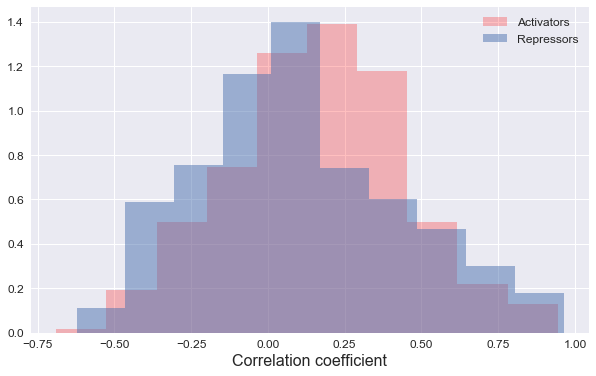

In [9]:
# compute correlation coefficients
corr_coefs = np.corrcoef(df_ecoli_ftr.iloc[:,1:].values)

# get data for activators and repressors
activators = corr_coefs[Adj_mat == 1]
repressors = corr_coefs[Adj_mat == -1]

plt.hist(activators, color='r', alpha = 0.25, density=True) 
plt.hist(repressors, alpha = 0.5, density=True) 

plt.legend(['Activators', 'Repressors'], loc='best')
plt.xlabel('Correlation coefficient')
plt.show()

***Use the absolute pairwise correlation coefficient to score all possible TF x target pairs. Plot precision/recall and ROC curves. How does your result compare to Figure 2 of [Faith et al. (2007)](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.0050008)?***

In [10]:
# get active transcription factors
abs_Adj_mat = np.abs(Adj_mat)
active_tfs = np.unique(np.where(abs_Adj_mat != 0)[0]) 
true_values = abs_Adj_mat[active_tfs,:].flatten()

# get estimated probabilities 
abs_corr_coefs = np.abs(corr_coefs)
abs_corr_coefs[active_tfs,active_tfs] = 0
predicted_probs = abs_corr_coefs[active_tfs,:].flatten()

In [11]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

# function to plot metrics' curves
def plot_metrics(true_values, predicted_probs):
    fig, ax = plt.subplots(1,2, figsize=(15,6))

    # compute precision and recall
    precision, recall, thresholds = precision_recall_curve(true_values, predicted_probs)
    avg_precision = average_precision_score(true_values, predicted_probs)
    
    # compute fpr, tpr and roc_auc 
    fpr, tpr, thresholds = roc_curve(true_values, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # plot precision-recall curve
    ax[0].plot(recall,precision)
    ax[0].set_xlim([0.0, np.median(recall)/3])
    ax[0].set_ylim([0.0, np.max(precision)])
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title(f'AUPRC={round(avg_precision,3)}') 

    # plot roc 
    ax[1].plot(fpr, tpr, color='r')
    ax[1].plot([0, 1], [0, 1], linestyle='--')
    ax[1].set_xlabel('False positive rate')
    ax[1].set_ylabel('True positive rate')
    ax[1].set_title(f'AUROC = {round(roc_auc,3)}')
    plt.show()

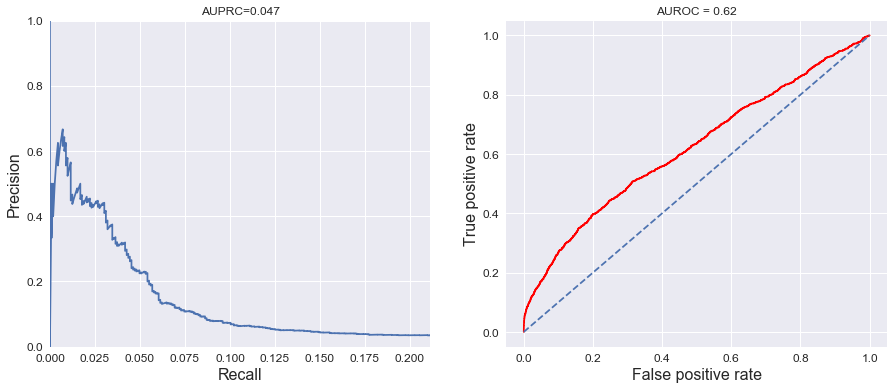

In [12]:
# plot metrics' curves for the obtained data
plot_metrics(true_values, predicted_probs)

Use your favourite machine learning method (lasso, elastic net, regression trees, random forest,...) to predict the expression level of every gene as a function of the expression level of transcription factors. Use the weight of a TF in a gene's prediction function as a predictive score for TF-target interactions. Do your non-linear and/or multi-variate scores obtain better AUPRC and AUROC with respect to RegulonDB than pairwise correlation values?

In [13]:
ecoli_tf_data = df_ecoli_ftr.iloc[active_tfs,1:].values
ecoli_target_data = df_ecoli_ftr.iloc[:,1:].values

In [14]:
from sklearn.linear_model import Ridge 
coefs = []

for i in range(len(ecoli_target_data)):
    model = Ridge(alpha = 1.0)
    model.fit(ecoli_tf_data.T, ecoli_target_data[i].reshape(-1,1))
    coefs += [model.coef_[0]]

coefs = np.array(coefs).T

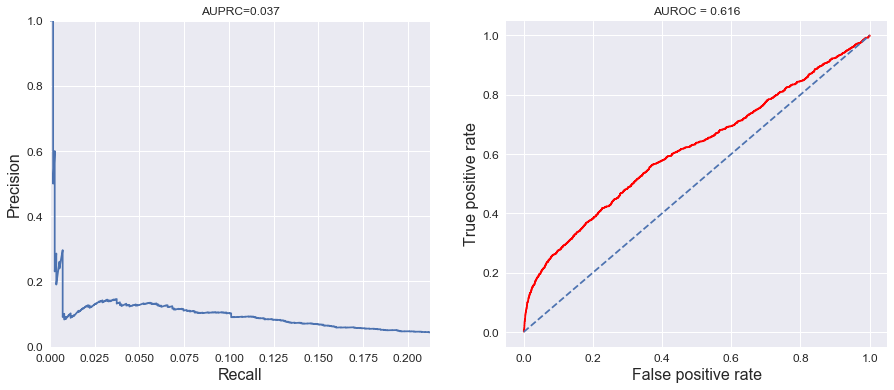

In [15]:
plot_metrics(true_values, coefs.flatten())